This notebook contains the code to preprocess the data and evaluate the GPT-2 models on the data.

In [ ]:
!pip install transformers

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchtext
import json
import random
import os
from scipy import interpolate
import re
import html

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Extract and Preprocess Data

In [ ]:
!unzip wikipedia_data_v3.zip

In [ ]:
def extract_text(folder_name):
  # this function extracts the text from the data
  folder_names = sorted(os.listdir(folder_name))
  # put all text in a list
  text = []
  for folder in folder_names:
    with open(folder_name + '/' + folder + '/text.json') as file:
      file_content = file.read()
      file_content_str = json.loads(file_content)
      # need to convert the file content to a dict to extract text
      file_content_dict = json.loads(file_content_str)
      text.append(file_content_dict["text"])
  return text

In [ ]:
text = extract_text('wikipedia_data_v3')

In [ ]:
def clean_text(text):
  # this function cleans the text data
  text_prepros = []
  for ex in text:
    new = re.sub('\n.+\|thumb.*\n?(.*)?', '', ex)
    new = re.sub('\n?(.*)?\|thumb.*\n', '', new)
    new = re.sub('\n.+thumb\|.*\n?(.*)?', '', new)
    new = re.sub('\n?(.*)?thumb\|.*\n', '', new)
    new = re.sub('\n.+\|thumbnail.*\n?(.*)?', '', new)
    new = re.sub('\n?(.*)?\|thumbnail.*\n', '', new)
    new = re.sub('\n.+thumbnail\|.*\n?(.*)?', '', new)
    new = re.sub('\n?(.*)?thumbnail\|.*\n', '', new)
    new = new.replace('\"', '')
    new = new.replace('"\"', '')
    new = html.unescape(new)
    new = new.encode('ascii', 'ignore').decode()
    new = re.sub(r'Accessed.*?\.', '', new)
    new = new.replace('  ', ' ')
    new = re.sub(r'(http|www)\S+', '', new)
    new = re.sub(r'External Links.*', '', new, flags=re.DOTALL)
    new = re.sub(r'References.*', '', new, flags=re.DOTALL)
    if '\nthumb |upright=1.35 |Centres of origin, as numbered by Nikolai Vavilov in the 1930s. Area 3 (gray) is no longer recognised as a centre of origin, and Papua New Guinea (area P, orange) was identified more recently.\n' in new:
      new = new.replace('\nthumb |upright=1.35 |Centres of origin, as numbered by Nikolai Vavilov in the 1930s. Area 3 (gray) is no longer recognised as a centre of origin, and Papua New Guinea (area P, orange) was identified more recently.\n', '')
    if '\n375px|Deprotonation equilibrium of acetic acid in water' in new:
      new = new.replace('\n375px|Deprotonation equilibrium of acetic acid in water', '')
    text_prepros.append(new)
  return text_prepros


In [ ]:
text_clean = clean_text(text)

### Tokenizers and Models

In [ ]:
tokenizergpt2 = GPT2Tokenizer.from_pretrained("gpt2")
tokenizergpt2.padding_side = "left"
tokenizergpt2.pad_token = tokenizergpt2.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
modelgpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
modelgpt2.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
tokenizergpt2(tokenizergpt2.eos_token)

{'input_ids': [50256], 'attention_mask': [1]}

In [ ]:
tokenizergpt2.eos_token

'<|endoftext|>'

In [ ]:
tokenizergpt2_xlarge = GPT2Tokenizer.from_pretrained("gpt2-xl")
tokenizergpt2_xlarge.padding_side = "left"
tokenizergpt2_xlarge.pad_token = tokenizergpt2_xlarge.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

In [ ]:
all_possible_tokens = list(tokenizergpt2_xlarge.get_vocab().keys())
#print(all_possible_tokens)

In [ ]:
modelgpt2_xlarge = GPT2LMHeadModel.from_pretrained("gpt2-xl")
modelgpt2_xlarge.to(device)

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

### Functions

In [ ]:
def encode(text, tokenizer):
  # encode all the text
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=1001)
  #inputs.to(device);
  # remove examples that don't have a 1000 tokens
  long_enough_rows = torch.nonzero(inputs["input_ids"][:, 0] != 50256).squeeze()
  input_ids = inputs["input_ids"][long_enough_rows]
  attention_mask = inputs["attention_mask"][long_enough_rows]
  return input_ids, attention_mask

In [ ]:
def measure_accuracy(input_ids, attention_mask, model, context_lengths, batch_size, file_name, difficulty_tensor_filename, top_x=1):
  # construct contexts and run batch generation
  # key is context length, value is the accuracy (number of correct next token predictions divided by number of examples)
  output_dict = {}
  difficulty_tensor = torch.zeros(input_ids.shape[0]).to(device)
  for c in context_lengths:
    output_dict[c] = 0
    if c >= 100:
      batch_size_to_use=2
    else:
      batch_size_to_use=batch_size
    difficulty_tensor_batch = torch.tensor([], dtype=torch.bool).to(device)
    for b in range(0, input_ids.size()[0], batch_size_to_use):
      input_ids_curr = input_ids[b:b+batch_size_to_use, 0:c]
      attention_mask_curr = attention_mask[b:b+batch_size_to_use, 0:c]
      correct_tokens = input_ids[b:b+batch_size_to_use, c]

      input_ids_curr = input_ids_curr.to(device);
      attention_mask_curr = attention_mask_curr.to(device);
      correct_tokens = correct_tokens.to(device);
      with torch.inference_mode():
        pred = model.generate(input_ids=input_ids_curr, attention_mask=attention_mask_curr, do_sample=False, max_new_tokens=1, pad_token_id=50256, output_scores=True, return_dict_in_generate=True)
      # get logits and softmax
      probs = torch.softmax(pred.scores[0], dim=-1)
      check_probs_sum_1 = torch.sum(probs, dim=1)
      if torch.all(check_probs_sum_1) == False:
        print("Error: Probabilities don't sum to one")
      # get the top x tokens based on probability
      top_values, top_ind = torch.topk(probs, k=top_x)
      results = torch.any(top_ind==correct_tokens.view(-1, 1), dim=1)
      difficulty_tensor_batch = torch.cat((difficulty_tensor_batch, results), dim=0)
      accuracy = results.sum().item()
      output_dict[c] += accuracy

    output_dict[c] = output_dict[c]/input_ids.size()[0]
    difficulty_tensor_batch = difficulty_tensor_batch.int()
    difficulty_tensor += difficulty_tensor_batch

  difficulty_tensor /= len(context_lengths)
  torch.save(difficulty_tensor, difficulty_tensor_filename)
  # save results to file
  with open(file_name, "w") as file:
    json.dump(output_dict, file)
  return output_dict

### Experiments

In [ ]:
def plot(output_filename, label_line):
  # plot the results
  with open(output_filename) as f:
    content = f.read()
  acc = json.loads(content)
  x_1 = list(acc)
  y_1 = np.array(list(acc.values()), dtype='float64')

  plt.figure(figsize=(11, 5))
  plt.plot(x_1, y_1, label=label_line)
  plt.legend()
  plt.xlabel("Context Length")
  plt.ylabel("Average accuracy")
  plt.title("Average Accuracy vs Context Length")
  plt.xticks(rotation = 25)
  plt.show()

In [ ]:
# 100 examples: GPT-2 small, top-1
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_100ex_p1.json", difficulty_tensor_filename = 'gpt2small_100ex_p1_diff.pt', top_x=1)

In [ ]:
# 100 examples: GPT-2 small, top-2
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_100ex_p2.json", difficulty_tensor_filename = 'gpt2small_100ex_p2_diff.pt', top_x=2)

In [ ]:
# 100 examples: GPT-2 small, top-3
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_100ex_p3.json", difficulty_tensor_filename = 'gpt2small_100ex_p3_diff.pt',top_x=3)

In [ ]:
# 100 examples: GPT-2 small, top-4
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_100ex_p4.json", difficulty_tensor_filename = 'gpt2small_100ex_p4_diff.pt', top_x=4)

In [ ]:
# 100 examples: GPT-2 small, top-5
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_100ex_p5.json", difficulty_tensor_filename = 'gpt2small_100ex_p5_diff.pt', top_x=5)

In [ ]:
# 100 examples: GPT-2 x-large, top-1
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_xlarge)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_xlarge, context_lengths=context_lengths, batch_size=8, file_name = "gpt2xlarge_100ex_p1.json", difficulty_tensor_filename = 'gpt2xlarge_100ex_p1_diff.pt', top_x=1)

In [ ]:
# 50 examples: GPT-2 x-large, top-1
random_50_ex = torch.randperm(input_ids.size(0))[:50]
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_xlarge)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids[random_50_ex], attention_mask=attention_mask[random_50_ex], model=modelgpt2_xlarge, context_lengths=context_lengths, batch_size=8, file_name = "gpt2xlarge_50ex_p1.json", difficulty_tensor_filename = 'gpt2xlarge_50ex_p1_diff.pt', top_x=1)

In [ ]:
# 75 examples: GPT-2 x-large, top-1
random_75_ex = torch.randperm(input_ids.size(0))[:75]
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_xlarge)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids[random_75_ex], attention_mask=attention_mask[random_75_ex], model=modelgpt2_xlarge, context_lengths=context_lengths, batch_size=8, file_name = "gpt2xlarge_75ex_p1.json", difficulty_tensor_filename = 'gpt2xlarge_75ex_p1_diff.pt', top_x=1)

In [ ]:
# 100 examples: GPT-2 x-large, top-2
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_xlarge)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_xlarge, context_lengths=context_lengths, batch_size=8, file_name = "gpt2xlarge_100ex_p2.json", difficulty_tensor_filename = 'gpt2xlarge_100ex_p2_diff.pt', top_x=2)

In [ ]:
# 100 examples: GPT-2 x-large, top-3
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_xlarge)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_xlarge, context_lengths=context_lengths, batch_size=8, file_name = "gpt2xlarge_100ex_p3.json", difficulty_tensor_filename = 'gpt2xlarge_100ex_p3_diff.pt', top_x=3)

In [ ]:
# 100 examples: GPT-2 x-large, top-4
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_xlarge)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_xlarge, context_lengths=context_lengths, batch_size=8, file_name = "gpt2xlarge_100ex_p4.json", difficulty_tensor_filename = 'gpt2xlarge_100ex_p4_diff.pt', top_x=4)

In [ ]:
# 100 examples: GPT-2 x-large, top-5
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_xlarge)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_xlarge, context_lengths=context_lengths, batch_size=8, file_name = "gpt2xlarge_100ex_p5.json", difficulty_tensor_filename = 'gpt2xlarge_100ex_p5_diff.pt', top_x=5)

### Plots

##### GPT-2 small vs x-large - 100 ex

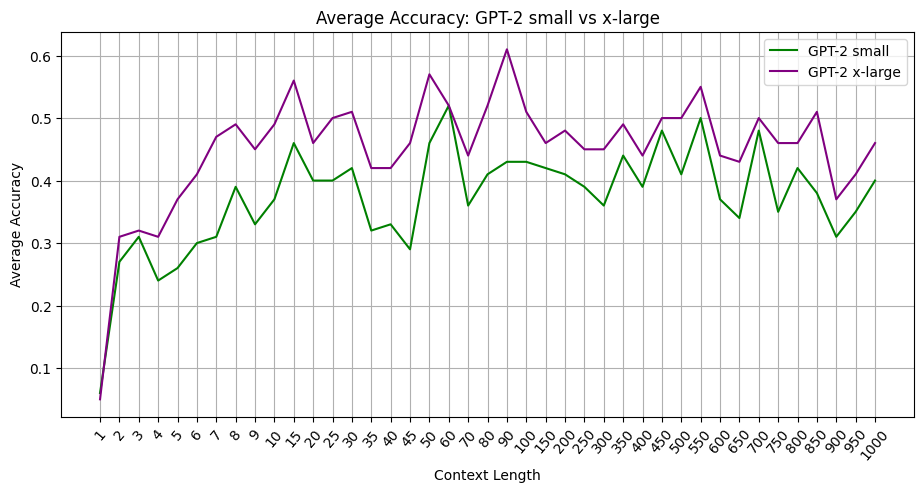

In [ ]:
with open("gpt2small_100ex_p1.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2xlarge_100ex_p1.json") as f:
  content = f.read()
acc_xlarge = json.loads(content)
x_1 = list(acc_small)
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = list(acc_xlarge)
y_2 = np.array(list(acc_xlarge.values()), dtype='float64')
plt.figure(figsize=(11, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color='green')
plt.plot(x_2, y_2, label="GPT-2 x-large", color='purple')
plt.xticks(rotation = 50)
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large")
plt.grid()
plt.show()

##### GPT-2 x-large (50 ex vs 75 ex vs 100 ex)

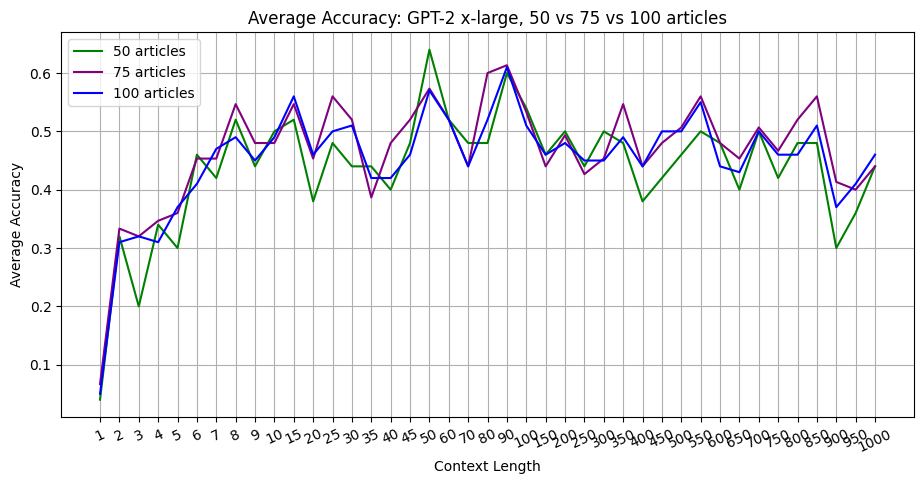

In [ ]:
with open("gpt2xlarge_50ex_p1.json") as f:
  content = f.read()
acc_xlarge = json.loads(content)
with open("gpt2xlarge_75ex_p1.json") as f:
  content = f.read()
acc_xlarge_data2 = json.loads(content)
with open("gpt2xlarge_100ex_p1.json") as f:
  content = f.read()
acc_xlarge_data3 = json.loads(content)
x_1 = list(acc_xlarge)
x_2 = list(acc_xlarge_data2)
x_3 = list(acc_xlarge_data3)
y_1 = np.array(list(acc_xlarge.values()), dtype='float64')
y_2 = np.array(list(acc_xlarge_data2.values()), dtype='float64')
y_3 = np.array(list(acc_xlarge_data3.values()), dtype='float64')
plt.figure(figsize=(11, 5))
plt.plot(x_1, y_1, label="50 articles", color='green')
plt.plot(x_2, y_2, label="75 articles", color='purple')
plt.plot(x_3, y_3, label="100 articles", color='blue')
#plt.xscale('log')
plt.xticks(rotation = 25)
plt.legend()
plt.grid()
plt.xlabel("Context Length")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy: GPT-2 x-large, 50 vs 75 vs 100 articles")
plt.show()

##### GPT-2 x-large (top 1 vs top 2 vs top top 3 vs top 4 vs top 5)

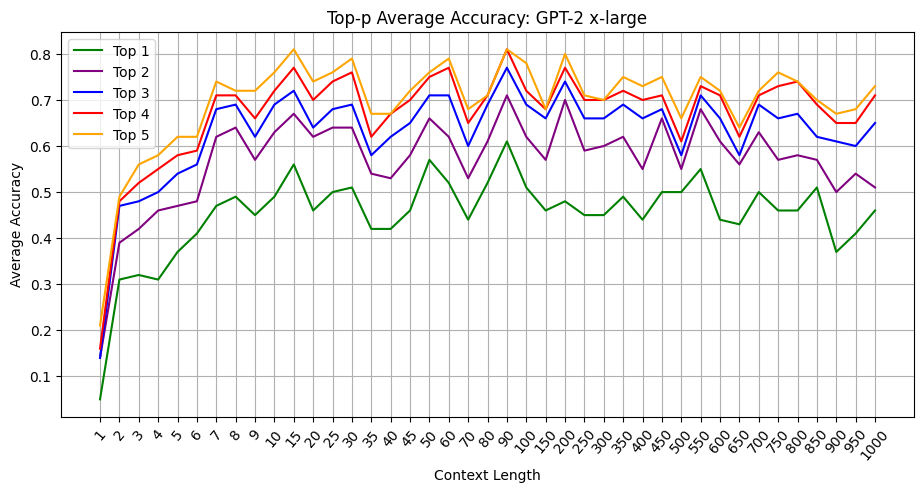

In [ ]:
with open("gpt2xlarge_100ex_p1.json") as f:
  content = f.read()
top1 = json.loads(content)
with open("gpt2xlarge_100ex_p2.json") as f:
  content = f.read()
top2 = json.loads(content)
with open("gpt2xlarge_100ex_p3.json") as f:
  content = f.read()
top3 = json.loads(content)
with open("gpt2xlarge_100ex_p4.json") as f:
  content = f.read()
top4 = json.loads(content)
with open("gpt2xlarge_100ex_p5.json") as f:
  content = f.read()
top5 = json.loads(content)
x_1 = list(top1)
y_1 = np.array(list(top1.values()), dtype='float64')
x_2 = list(top2)
y_2 = np.array(list(top2.values()), dtype='float64')
x_3 = list(top3)
y_3 = np.array(list(top3.values()), dtype='float64')
x_4 = list(top4)
y_4 = np.array(list(top4.values()), dtype='float64')
x_5 = list(top5)
y_5 = np.array(list(top5.values()), dtype='float64')
plt.figure(figsize=(11, 5))
plt.plot(x_1, y_1, label="Top 1", color='green')
plt.plot(x_2, y_2, label="Top 2", color='purple')
plt.plot(x_3, y_3, label="Top 3", color='blue')
plt.plot(x_4, y_4, label="Top 4", color='red')
plt.plot(x_5, y_5, label="Top 5", color='orange')
plt.xticks(rotation = 50)
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average Accuracy")
plt.title("Top-p Average Accuracy: GPT-2 x-large")
plt.grid()
plt.show()